# Ocean Wave Prediction Model Using RNN-LSTM

Predicting wave behaviors is an important tool for the safety of ship navigation and offshore operations. 

In order to predict wave behaviors we need to collect wave data. Wave monitoring buoys are used for collecting the data. Wave monitoring buoys continuously measures the wave height, wave period and wave direction. 

As the wave monitoring buoy floats up and down each passing wave, its motion is measured and electronically processed. Data from the wave monitoring buoys are transmitted to a nearby receiver station as a radio signal.

Measured and derived wave data in this study is collected by oceanographic wave measuring buoys anchored at Mooloolaba/Queensland/Australia. 

My aim is to create a Long Short Time Memory (LSTM) deep learning model to predict future wave behaviors. In order to achive this I will divide the data set into two part (train and test). Every 30 samples from the training data will be investigated and the 31st sample features will be predicted by the model. Once the model is properly trained, test data will be used as real time wave data. And lastly I will compare these real data samples and my model's predictions to evaluate the model's success.

wave_monitoring_buoy![image.png](attachment:image.png)

References: 
1. https://www.qld.gov.au/environment/coasts-waterways/beach/monitoring/waves 
2. https://www.data.qld.gov.au/dataset/coastal-data-system-waves-mooloolaba

**The wave data used in this study contains following features:**
* Date/Time: Date and 30 minute wave record
* Hs : The significant wave height (in metres), defined as the average of the highest one-third of wave heights in a 30 minute wave record.
* Hmax: The height (in metres) of the highest single wave in a wave record.
* Tz: The average of the zero up-crossing wave periods (in seconds) in a wave record.
* Tp: This is the wave period (in seconds) of those waves that are producing the most energy in a wave record.
* Peak Direction: The direction that peak waves are coming from, shown in degrees from true north.
* SST: The sea surface temperature at the wave monitoring buoy, in degrees Celsius.

wave_graph![image.png](attachment:image.png)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:

# Load and preprocess the data
df = pd.read_csv("D:\TISS\Resume\Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv")

In [7]:
# Deleting NaN values
df.replace(-99.90, np.nan, inplace=True)
df.drop('Date/Time', axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,0.763,1.15,4.520,5.513,49.0,25.65
1,0.770,1.41,4.582,5.647,75.0,25.50
2,0.747,1.16,4.515,5.083,91.0,25.45
3,0.718,1.61,4.614,6.181,68.0,25.45
4,0.707,1.34,4.568,4.705,73.0,25.50


## Visualization of the Features

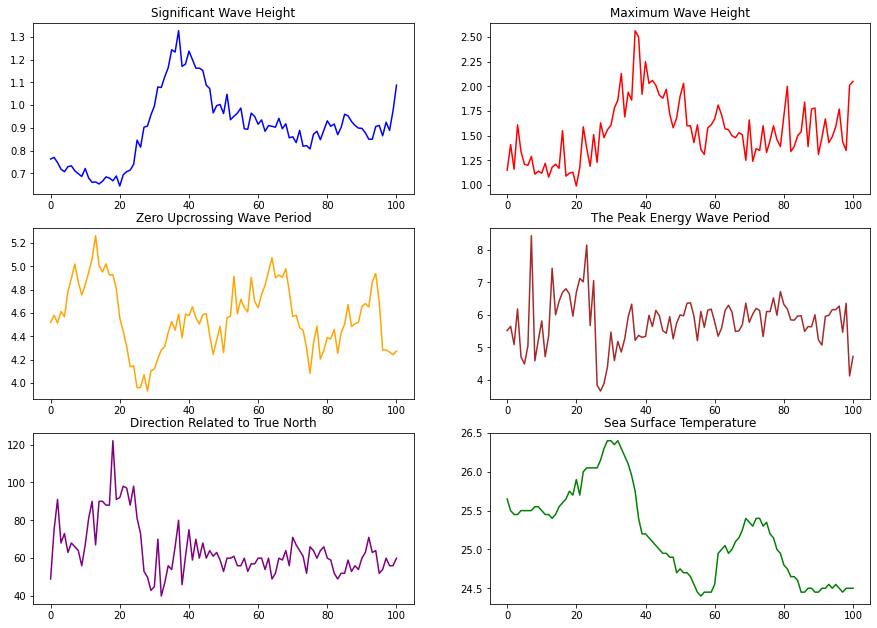

In [8]:
df_graph = df.loc[0:100]

plt.figure(figsize=(15,22))
plt.subplot(6,2,1)
plt.plot(df_graph['Hs'], color='blue')
plt.title('Significant Wave Height')

plt.subplot(6,2,2)
plt.plot(df_graph['Hmax'], color='red')
plt.title('Maximum Wave Height')

plt.subplot(6,2,3)
plt.plot(df_graph['Tz'], color='orange')
plt.title('Zero Upcrossing Wave Period')

plt.subplot(6,2,4)
plt.plot(df_graph['Tp'], color='brown')
plt.title('The Peak Energy Wave Period')

plt.subplot(6,2,5)
plt.plot(df_graph['Peak Direction'], color='purple')
plt.title('Direction Related to True North')

plt.subplot(6,2,6)
plt.plot(df_graph['SST'], color='green')
plt.title('Sea Surface Temperature')
plt.show();

## Initial Statistics

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43454 entries, 0 to 43453
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Hs              43454 non-null  float64
 1   Hmax            43454 non-null  float64
 2   Tz              43454 non-null  float64
 3   Tp              43454 non-null  float64
 4   Peak Direction  43454 non-null  float64
 5   SST             43454 non-null  float64
dtypes: float64(6)
memory usage: 2.0 MB
None


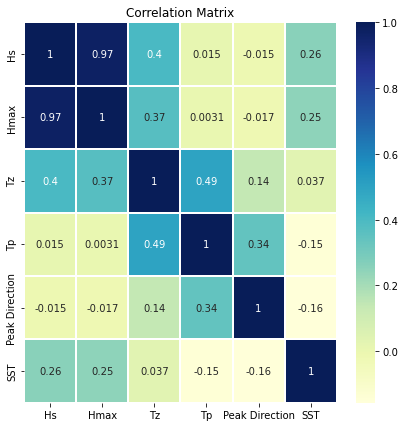

In [10]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), linewidth=.1, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show();

## Feature Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Scaling all the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(df)
print('Shape of the scaled data matrix: ', data.shape)

Shape of the scaled data matrix:  (43454, 6)


## Train and Test Split

In [12]:
# Separete data into 2 groups for train and test
train = data[:42000,]
test = data[42000: ,]

# Shapes of our datasets
print('Shape of train data: ', train.shape)
print('Shape of test data: ', test.shape)

Shape of train data:  (42000, 6)
Shape of test data:  (1454, 6)


In [22]:
# Separete every 30 samples as the input and get the 31st sample as the output.
def prepare_data(data):
    databatch = 30
    x_list = []
    y_list = []
    
    for i in range(len(data)-databatch-1):
        x_list.append(data[i:i+databatch])
        y_list.append(data[i+databatch+1])
        
    X_data = np.array(x_list)
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[2], X_data.shape[1]))
    y_data = np.array(y_list)
    
    return X_data, y_data

In [23]:
# Executing the separation
X_train, y_train = prepare_data(train)
X_test, y_test = prepare_data(test)
print('X_train Shape : ', X_train.shape, 'y_train shape :', y_train.shape)
print('X_test Shape  : ', X_test.shape, ' y_test shape  :', y_test.shape)

X_train Shape :  (41969, 6, 30) y_train shape : (41969, 6)
X_test Shape  :  (1423, 6, 30)  y_test shape  : (1423, 6)


## Creating the LSTM Model

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

def lstm_model(x_data, y_data, num_epochs, batch_size, learning_rate):
    # Creating the model
    model = Sequential()
    # Adding the first layer
    model.add(LSTM(32, input_shape=(x_data.shape[1], x_data.shape[2]), return_sequences=True))
    # Adding the second layer 
    model.add(LSTM(16, return_sequences=True))
    # Adding a dropout value in order to prevent overfiting
    model.add(Dropout(0.2))
    # Adding the third layer
    model.add(LSTM(10))
    # Adding the output layer. 6 nodes are selected because the data has 6 features
    model.add(Dense(6))
    
    # Choosing the optimizer
    optimizer = Adam(lr=learning_rate)
    
    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    # Fitting the model
    history = model.fit(x_data, y_data, validation_split=0.25, epochs=num_epochs, batch_size=batch_size)
    
    return model, history

In [25]:
history = lstm_model(X_train, y_train, num_epochs=15, batch_size=200, learning_rate=.001)

Epoch 1/15
158/158 [==============================] - 18s 40ms/step - loss: 0.0196 - accuracy: 0.5822 - val_loss: 0.0040 - val_accuracy: 0.9008
Epoch 2/15
158/158 [==============================] - 4s 23ms/step - loss: 0.0059 - accuracy: 0.7541 - val_loss: 0.0034 - val_accuracy: 0.9036
Epoch 3/15
158/158 [==============================] - 4s 24ms/step - loss: 0.0051 - accuracy: 0.7794 - val_loss: 0.0030 - val_accuracy: 0.9106
Epoch 4/15
158/158 [==============================] - 4s 23ms/step - loss: 0.0045 - accuracy: 0.7933 - val_loss: 0.0026 - val_accuracy: 0.9125
Epoch 5/15
158/158 [==============================] - 4s 23ms/step - loss: 0.0039 - accuracy: 0.8033 - val_loss: 0.0023 - val_accuracy: 0.9141
Epoch 6/15
158/158 [==============================] - 4s 23ms/step - loss: 0.0034 - accuracy: 0.8157 - val_loss: 0.0020 - val_accuracy: 0.9256
Epoch 7/15
158/158 [==============================] - 4s 22ms/step - loss: 0.0031 - accuracy: 0.8203 - val_loss: 0.0018 - val_accuracy: 0.924

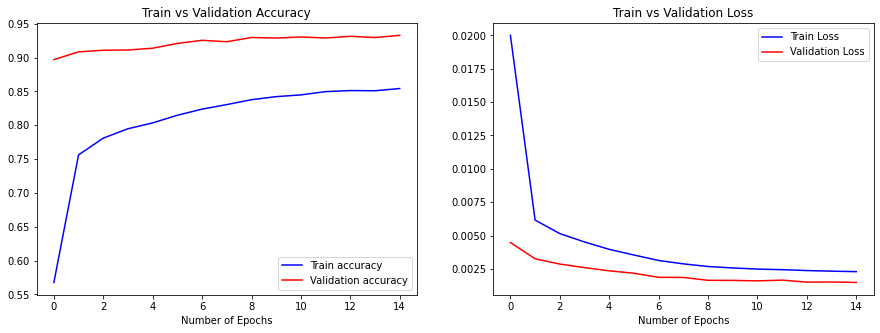

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history[1].history['accuracy'], color='blue', label='Train accuracy')
plt.plot(history[1].history['val_accuracy'], color='red', label='Validation accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history[1].history['loss'], color='blue', label='Train Loss')
plt.plot(history[1].history['val_loss'], color='red', label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show();

In [18]:
# Defining function to predict datas
def predicting(data, y_real):
    predicted_data = history[0].predict(data)
    # Invert scaling process to get the normal values range for the features 
    predicted_data = scaler.inverse_transform(predicted_data)
    y_real = scaler.inverse_transform(y_real)
    
    return predicted_data, y_real

In [29]:
# Executing predictions
train_prediction, y_train = predicting(X_train, y_train)
test_prediction, y_test = predicting(X_test, y_test)

45/45 [==============================] - 0s 7ms/step


## Evaluating the Model Success

In [30]:
import math
from sklearn.metrics import mean_squared_error

def examine_rmse(y_data, predicted_data):
    Score_Hs = math.sqrt(mean_squared_error(y_data[:,0], predicted_data[:,0]))
    Score_Hmax = math.sqrt(mean_squared_error(y_data[:,1], predicted_data[:,1]))
    Score_Tz = math.sqrt(mean_squared_error(y_data[:,2], predicted_data[:,2]))
    Score_Tp = math.sqrt(mean_squared_error(y_data[:,3], predicted_data[:,3]))
    Score_Dir = math.sqrt(mean_squared_error(y_data[:,4], predicted_data[:,4]))
    Score_SST = math.sqrt(mean_squared_error(y_data[:,5], predicted_data[:,5]))
    
    print('RMSE_Hs       : ', Score_Hs)
    print('RMSE_Hmax     : ', Score_Hmax)
    print('RMSE_Tz       : ', Score_Tz)
    print('RMSE_Tp       : ', Score_Tp)
    print('RMSE_Direction: ', Score_Dir)
    print('RMSE_SST      : ', Score_SST)

In [31]:
# Executing the RMSE comparison
print('Trainin Data Errors')
print(examine_rmse(y_train, train_prediction),'\n')
print('Test Data Errors')
print(examine_rmse(y_test, test_prediction))

Trainin Data Errors
RMSE_Hs       :  0.10272568342973074
RMSE_Hmax     :  0.27201288757896025
RMSE_Tz       :  0.32186196349721474
RMSE_Tp       :  1.3286149307454438
RMSE_Direction:  13.97571025329391
RMSE_SST      :  0.20074737594053613
None 

Test Data Errors
RMSE_Hs       :  0.09752374236306173
RMSE_Hmax     :  0.26828154614068783
RMSE_Tz       :  0.34373526358360024
RMSE_Tp       :  1.9651829912183312
RMSE_Direction:  15.074500686736132
RMSE_SST      :  0.20989805274151507
None


## Visualization of the Real and Predicted Values
For the ease of understanding the model, the real and predicted datas are limited by 123 samples (Samples from 1300-1423).

C:\Users\91917\AppData\Local\Temp\ipykernel_14664\1911447692.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis='y')
C:\Users\91917\AppData\Local\Temp\ipykernel_14664\1911447692.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis='y')
C:\Users\91917\AppData\Local\Temp\ipykernel_14664\1911447692.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis='y')
C:\Users\91917\AppData\Local\Temp\ipykernel_14664\1911447692.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for t

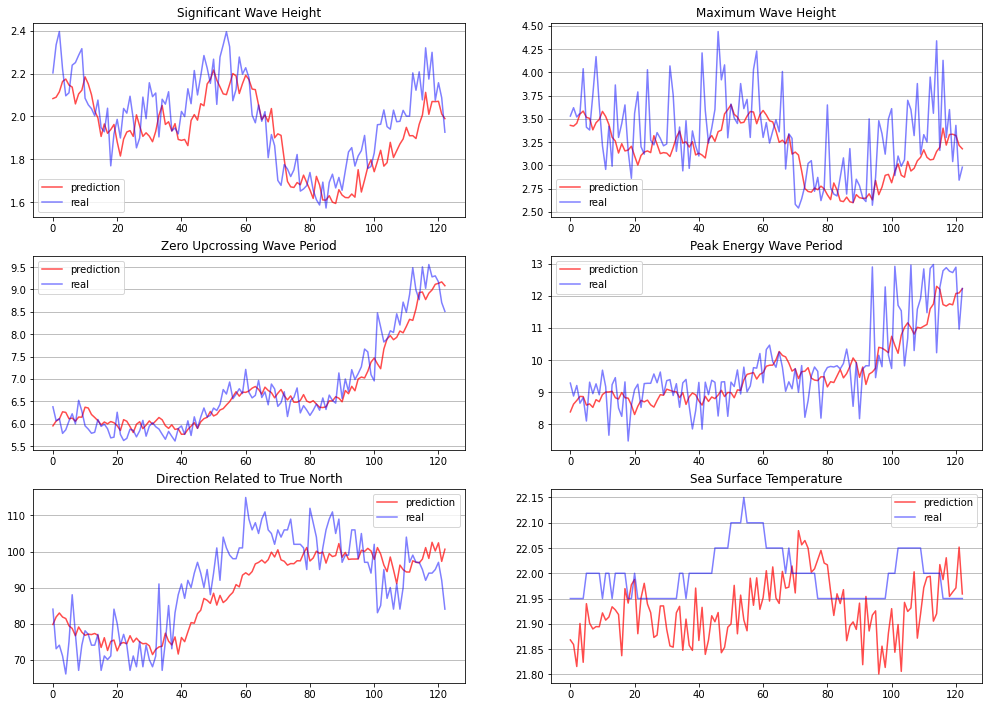

In [32]:
plt.figure(figsize=(17,25))


plt.subplot(6,2,1)
plt.plot(test_prediction[1300:,0], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,0], color='blue', alpha=0.5, label='real')
plt.title('Significant Wave Height')
plt.legend()
plt.grid(b=True, axis='y')

plt.subplot(6,2,2)
plt.plot(test_prediction[1300:,1], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,1], color='blue', alpha=0.5, label='real')
plt.title('Maximum Wave Height')
plt.legend()
plt.grid(b=True, axis='y')

plt.subplot(6,2,3)
plt.plot(test_prediction[1300:,2], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,2], color='blue', alpha=0.5, label='real')
plt.title('Zero Upcrossing Wave Period')
plt.legend()
plt.grid(b=True, axis='y')

plt.subplot(6,2,4)
plt.plot(test_prediction[1300:,3], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,3], color='blue', alpha=0.5, label='real')
plt.title('Peak Energy Wave Period')
plt.legend()
plt.grid(b=True, axis='y')

plt.subplot(6,2,5)
plt.plot(test_prediction[1300:,4], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,4], color='blue', alpha=0.5, label='real')
plt.title('Direction Related to True North')
plt.legend()
plt.grid(b=True, axis='y')

plt.subplot(6,2,6)
plt.plot(test_prediction[1300:,5], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,5], color='blue', alpha=0.5, label='real')
plt.title('Sea Surface Temperature')
plt.legend()
plt.grid(b=True, axis='y')
plt.show();

## Conclusion

LSTM model is capable of predicting future values by looking at a defined batch of samples. 30 samples are used as a batch for the model in order to predict 31st sample. 

### After the training process LSTM model reached:
#### a. 0.85 training model accuracy and 0.93 validation model accuracy
#### b. 0.0023 training loss value and 0.0015 validation loss value
#### c. 0.09 - 0.26 meters of error for predicting wave height (RMSE Hs and RMSE Hmax)
#### d. 0.3 - 1.96 seconds of error for predicting wave period (RMSE Tz and RMSE Tp)
#### e. App. 15 degrees of error for predicting the wave direction (RMSE Direction)
#### f. 0.2 degrees celcius of error for predicting the sea surface temperature (RMSE SST)